# Morphological Drainage

Morphological drainage is a quick simulation of fluid invasion in porous media using a geometric approach rather than solving fluid dynamics equations. It provides an efficient means to approximate drainage patterns by identifying which pores are invaded as capillary pressure increases and is commonly used for multiphase simulation initialization.

The method can also be used to gauge whether the resolution of an image is sufficient for porous media analysis.

## Import packages

In [1]:
import dpm_tools as dpm
import porespy as ps
import numpy as np
import matplotlib.pyplot as plt

[17:01:48] ERROR    PARDISO solver not installed, run `pip install pypardiso`. Otherwise,          ]8;id=258551;file://C:\Users\bcc2459\AppData\Roaming\Python\Python312\site-packages\openpnm\utils\_workspace.py\_workspace.py]8;;\:]8;id=118929;file://C:\Users\bcc2459\AppData\Roaming\Python\Python312\site-packages\openpnm\utils\_workspace.py#56\56]8;;\
                    simulations will be slow. Apple M chips not supported.                                         

## Demonstration image

To demonstrate the distance transforms, we generate a simple 3D binary image using the [PoreSpy blobs generator](https://porespy.org/examples/generators/tutorials/making_blobs.html) function. The example image size is $100 \times 100 \times 100$.

(-0.5, 99.5, 99.5, -0.5)

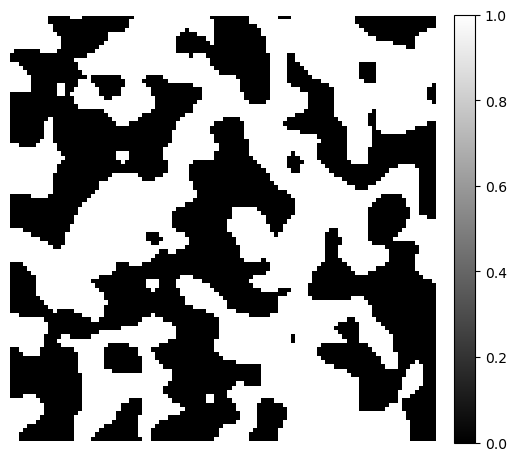

In [2]:
image = ps.generators.blobs(shape=[100, 100, 100])

fig, ax = plt.subplots(figsize=[6, 6])
im = ax.imshow(image[1], cmap="binary_r")
fig.colorbar(im, fraction=0.046, pad=0.04)
ax.axis(False)

## Morphological Drainage

The morphological drainage simulation demonstrated here was originally proposed in [Hilpert and Miller (2001)](https://ui.adsabs.harvard.edu/abs/2001AdWR...24..243H/abstract) and has been widely used, such as in the [LBPM software](https://link.springer.com/article/10.1007/s10596-020-10028-9). The algorithm estimates the multiphase fluid configurations for a given porous medium. Morphological drainage is a useful pre-processing tool for computational SCAL workflows, such as in multiphase lattice Boltzmann simulations.

The algorithm operates as follows:

1. The Euclidean distance transform is applied to the input binary image. The maximum value of the distance transform is interpreted as the radius for the largest sphere that can be inserted into the pore space.
2. Perform morphological erosion for the pore space with the specified sphere radius.
3. Label the eroded pore space, and leave only the pore space that is still connected with the non-wetting phase.
4. Perform morphological dilation for the labelled pore space with specified radius.
5. Compute the wetting phase saturation of the result of step 4.
6. Decrease the sphere radius. This smaller sphere covers a larger fraction of the pore space (i.e. more non-wetting phase can invade the pore space).
7. Repeat steps 2-5 until a target saturation is achieved.

**Inputs:**

 - a digital rock image
 - a target wetting phase saturation value (i.e. how much oil to inject using a drainage process)

**Outputs:**

 - a digital rock image with estimated oil configuration at target wetting phase saturation
 - a list of the water saturation Sw and radii r

This algorithm has been wrapped in a convenient function, ``dpm_tools.metrics.morph_drain()``.

In [3]:
radii, sw, configs = dpm.metrics.morph_drain(image, target_saturation=0.05)


7.297088384628296 1.0
6.932233965396881 0.9937287936822814
6.585622267127037 0.9920630976777653
6.256341153770685 0.9878690421055352
5.94352409608215 0.9828003967457309
5.646347891278043 0.9778828168946895
5.364030496714141 0.9743109126940744
5.095828971878434 0.970939766603789
4.841037523284512 0.9566720268419556
4.598985647120286 0.9545730113517779
4.369036364764272 0.9394386326186213
4.1505845465260585 0.9200306901507276
3.9430553191997557 0.8975676465385127
3.745902553239768 0.8975676465385127
3.5586074255777795 0.7993750658426971
3.3806770542988906 0.765933932692365
3.211643201583946 0.6093505574516044
3.0510610415047488 0.39894413160191056
2.898507989429511 0.22615898054634034
2.7535825899580355 0.13647973635093313
2.615903460460134 0.13647973635093313
2.4851082874371273 0.13647973635093313
2.360852873065271 0.10131725148233031
2.2428102294120076 0.10131725148233031
2.1306697179414074 0.06238409200684565
2.024136232044337 0.06238409200684565
1.9229294204421201 0.04104012578191309

### Phase Configurations

(0.0, 256.0, 0.0, 256.0)

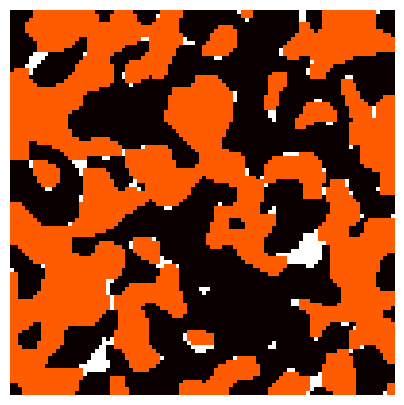

In [7]:
fig, ax = plt.subplots(figsize=[5, 5])
ax.imshow(configs[50], cmap='hot', extent=[0, 256, 0, 256])
ax.axis(False)

### Mercury Injection Curve

The radius of morphological opening is decreased to decrease the water saturation.

We can use the radius steps to provide an approximation of oil drainage under water-wet conditions, though it may miss irreducible water saturation.

Here, we define a function to compute and plot the curvature ($1/r$) vs. water saturation. Note how curvature relates to the capillary pressure curve:

$$ P_c = P_{nw} - P_w = \frac{2\sigma\cos\theta}{r}.$$

Text(0, 0.5, 'Curvature')

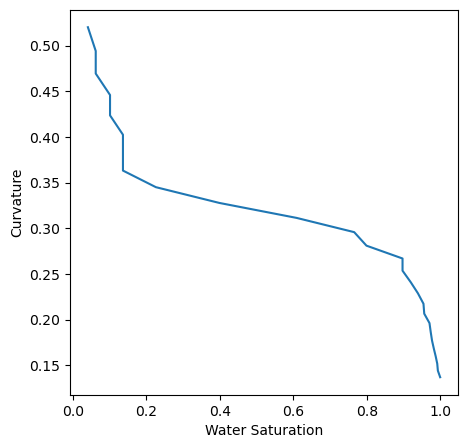

In [9]:
pc = 1 / radii

fig, ax = plt.subplots(figsize=[5, 5])
ax.plot(sw, pc)
ax.set_xlabel('Water Saturation')
ax.set_ylabel('Curvature')


### Morphological Drainage as Image Quality Control

The morphological opening tells us how large the flow channels are likely to be. Under-resolved flow channels will lead to "bad" simulation results. This is clear if the porespace is not well-connected.

**Rule of thumb:** 5 - 10 voxels across a pore-throat helps ensure scale separation between water films and flow channels

For multiphase simulations, we should focus on the saturation value where the drainage curve crosses the 5-10 voxel threshold. The saturation at this point should be less than ~0.3 because we want to ensure that we are adequately resolving flow behaviors where relative permeability crossover occurs.

Text(0, 0.5, 'Radius (Voxels)')

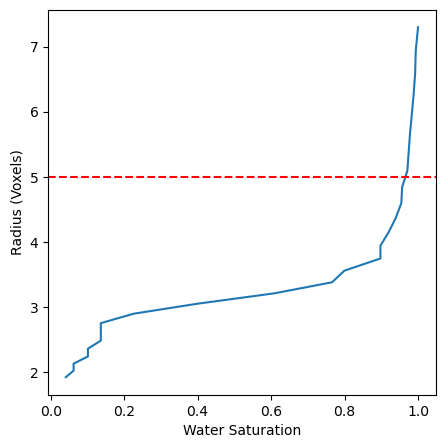

In [11]:
fig, ax = plt.subplots(figsize=[5, 5])
ax.plot(sw, radii)
ax.axhline(y=5,color='r',linestyle='dashed')
ax.set_xlabel('Water Saturation')
ax.set_ylabel('Radius (Voxels)')

***Note:*** This image is *not* well resolved enough to perform trustworthy flow simulations.